In [2]:
import numpy as np
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
import symengine
import time
from tqdm import tqdm
import warnings

In [1]:
# Fix for Apple Silicon compilation issues with jitcdde
import os
import sys

# Remove problematic CPU-specific flags
os.environ['CFLAGS'] = '-O2'
os.environ['CXXFLAGS'] = '-O2'

# Alternative: Use generic optimization without CPU-specific targeting
# This prevents the 'unknown target CPU' error on Apple Silicon

Running simulations: 100%|██████████| 80/80 [00:53<00:00,  1.50it/s]


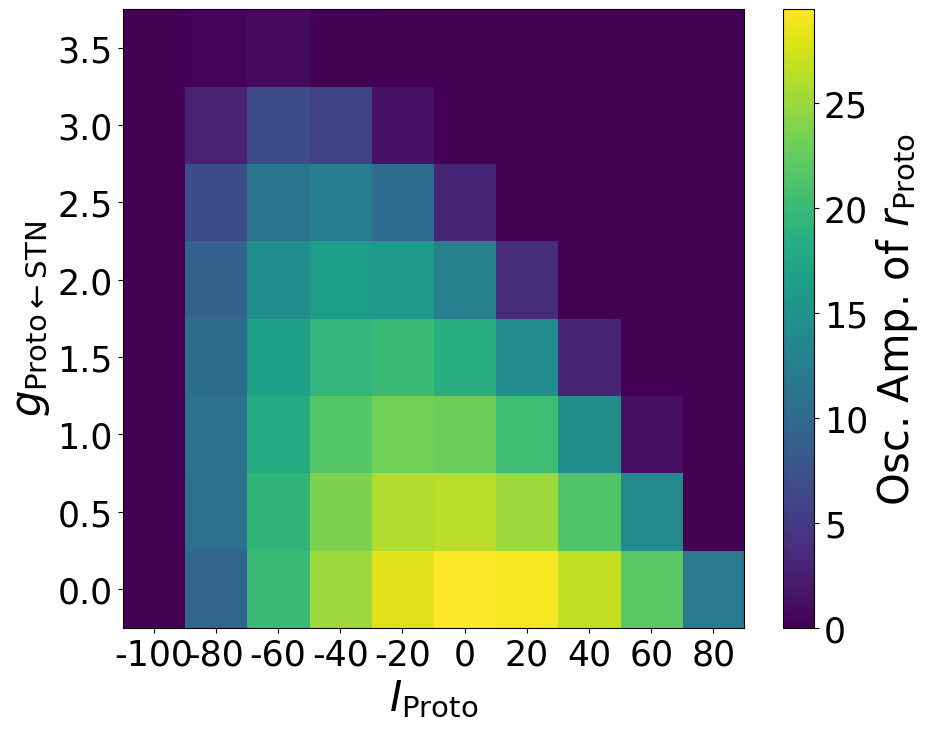

In [64]:
# Suppress specific jitcdde warnings
warnings.filterwarnings("ignore", message="Differential equation does not include a delay term.")
warnings.filterwarnings("ignore", message="You did not explicitly handle initial discontinuities.*")
warnings.filterwarnings("ignore", message="The target time is smaller than the current time.*")

# This model represents population firing rates for basal ganglia nuclei:
# x1: STN (Subthalamic Nucleus)
# x2: Proto (Prototypical Neurons)
# x3: FSI (Fast-Spiking Interneurons)
# x4: D2 (D2 Receptor-Expressing Medium Spiny Neurons)

# Function to create and run the DDE system for specific parameter values
def run_simulation(g21, I2):
    # Activation function (sigmoid)
    def f(x):
        return 1/(1+symengine.exp(-x))

    # Parameters
    # Neuron 1
    a1 = 31.3
    b1 = 0.127
    g12 = 0.4
    c1 = -2.33
    t1 = 12
    I1 = 0

    # Neuron 2
    a2 = 108
    b2 = 0.0198
    g24 = 50
    c2 = -2.33
    t2 = 10
    # I2 is now a parameter passed to the function

    # Neuron 3
    a3 = 41.6
    b3 = 0.0327
    g32 = 4
    c3 = -5.28
    t3 = 20
    I3 = -20

    # Neuron 4
    a4 = 6.61
    b4 = 0.0326
    g43 = 10
    c4 = -5.28
    t4 = 20
    I4 = -80

    # Fixed delay value of 0
    d = 0

    # Define the differential equations
    def dde_system():
        """
        Population firing rate model:
                    x3 (FSI)
                  /        \
        x1 (STN) <-> x2 (Proto)   x4 (D2) <---
        """
        # In jitcdde, y(0) is x1 (STN), y(1) is x2 (Proto), y(2) is x3 (FSI), and y(3) is x4 (D2)
        # Using a fixed delay of 0

        # x1 equation
        yield (-y(0) + a1 * f(b1 * (-g12 * y(1, t-d) + I1) - c1)) / t1

        # x2 equation with variable I2
        yield (-y(1) + a2 * f(b2 * (g21 * y(0) - g24 * y(3) + I2) - c2)) / t2

        # x3 equation
        yield (-y(2) + a3 * f(b3 * (-g32 * y(1) + I3) - c3)) / t3

        # x4 equation
        yield (-y(3) + a4 * f(b4 * (-g43 * y(2) + I4) - c4)) / t4

    # Set up the DDE solver
    DDE = jitcdde(dde_system)

    # Set initial conditions
    initial_conditions = [15, 60, 0.15, 1]  # [x1, x2, x3, x4]
    DDE.constant_past(initial_conditions)

    # Set integration parameters
    DDE.set_integration_parameters()

    # Handle initial discontinuities explicitly to avoid warning
    DDE.initial_discontinuities_handled = True

    # Compile the DDE system (only needed once per run)
    DDE.compile_C()

    # Solve the system
    total_time = 4000
    cutoff_time = 3000  # Start measuring amplitude after this time
    dt = 0.5
    times = np.arange(0, total_time, dt)
    solution = np.zeros((len(times), 4))

    for i, time_point in enumerate(times):
        solution[i] = DDE.integrate(time_point)

    # Calculate amplitude of x2 after cutoff_time
    cutoff_index = int(cutoff_time / dt)
    x2_late = solution[cutoff_index:, 1]  # Get x2 values after cutoff

    # Calculate amplitude as max - min
    amplitude = np.max(x2_late) - np.min(x2_late)

    return amplitude


# Define parameter ranges for heatmap
g21_values = np.arange(0,4,0.5)  # Range of g21 values
I2_values = np.arange(-100, 100, 20)   # Range of I2 values

# Create a matrix to store oscillation amplitudes - now g21 on y-axis, I2 on x-axis
amplitudes = np.zeros((len(g21_values), len(I2_values)))

# Main loop to fill the amplitude matrix
start_time = time.time()

# Create all parameter combinations
param_combinations = [(j, g21, i, I2) for j, g21 in enumerate(g21_values) for i, I2 in enumerate(I2_values)]
total_simulations = len(param_combinations)

# Use tqdm for progress tracking
for j, g21, i, I2 in tqdm(param_combinations, desc="Running simulations", total=total_simulations):
    # Run simulation and get amplitude
    amplitude = run_simulation(g21, I2)

    # Store in matrix
    amplitudes[j, i] = amplitude

    # Optional: display additional information in the description
    # tqdm.write(f"Completed: g21={g21:.2f}, I2={I2:.2f}, Amplitude: {amplitude:.2f}")

# Create heatmap
plt.figure(figsize=(10, 8))
plt.imshow(amplitudes, cmap='viridis', origin='lower', aspect='auto',)

plt.colorbar(label=r'Osc. Amp. of $r_{\text{Proto}}$')
plt.xlabel(r'$I_{\text{Proto}}$')
plt.ylabel(r'$g_{\text{Proto}\leftarrow\text{STN}}$')

plt.xticks(np.arange(len(I2_values)), I2_values)
plt.yticks(np.arange(len(g21_values)), g21_values)

# Add grid
plt.grid(False)

# Save figure
plt.tight_layout()
# plt.savefig('oscillation_amplitude_heatmap_g21_I2.png', dpi=300)
plt.savefig('oscillation_amplitude_heatmap_g_I.png', dpi=300)
plt.show()

# Also save the data to a numpy file for later analysis
np.savez('oscillation_data_g21_I2.npz',
         amplitudes=amplitudes,
         g21_values=g21_values,
         I2_values=I2_values)

In [3]:
from scipy.fft import fft, fftfreq

def calculate_phase_difference(signal1, signal2, dt, min_power_threshold=1e-6):
        """
        Calculate the phase difference between two populations' firing rates.

        Args:
            pop1 (str): The name of the first population.
            pop2 (str): The name of the second population.
            bin_width (int): The width of each bin in milliseconds.
            drop_initial (int): The initial portion of data to drop in milliseconds.

        Returns:
        --------
        phase_diff : float
            Phase difference in radians (wrapped to [-π, π])
        dominant_freq : float
            Dominant frequency in Hz
        """

        # FFT of both signals
        fft1 = fft(signal1 - signal1.mean())
        fft2 = fft(signal2 - signal2.mean())

        fs = 1000.0 / dt  # Sampling frequency in Hz

        # Frequency array (positive frequencies only)
        freqs = fftfreq(len(signal1), 1 / fs)
        pos_freqs = freqs[:len(freqs) // 2]
        pos_fft1 = fft1[:len(freqs) // 2]
        pos_fft2 = fft2[:len(freqs) // 2]

        # Calculate power spectra
        power1 = np.abs(pos_fft1) ** 2
        power2 = np.abs(pos_fft2) ** 2

        # Find dominant frequency from signal1 (our reference)
        dominant_idx = np.argmax(np.abs(pos_fft1))
        dominant_freq = pos_freqs[dominant_idx]
        max_power1 = power1[dominant_idx]
        max_power2 = power2[dominant_idx]

        # Check if signals have sufficient power at the dominant frequency
        if max_power1 < min_power_threshold:
            print(f"Warning: Signal 1 has no significant frequency components (likely constant or noise)")
            return np.nan, np.nan

        if max_power2 < min_power_threshold:
            print("Warning: Signal 2 has no significant frequency components (likely constant or noise)")
            return np.nan, np.nan

        # Extract phases at dominant frequency
        phase1 = np.angle(pos_fft1[dominant_idx])
        phase2 = np.angle(pos_fft2[dominant_idx])

        # Calculate phase difference with signal1 as reference
        phase_diff = phase2 - phase1

        # Wrap to [-π, π]
        phase_diff = np.degrees(np.arctan2(np.sin(phase_diff), np.cos(phase_diff)))

        return round(phase_diff, 1), round(dominant_freq, 1)

Running simulations:  16%|█▌        | 4/25 [00:02<00:14,  1.49it/s]

Running simulations:  20%|██        | 5/25 [00:03<00:13,  1.48it/s]

Running simulations: 100%|██████████| 25/25 [00:16<00:00,  1.48it/s]


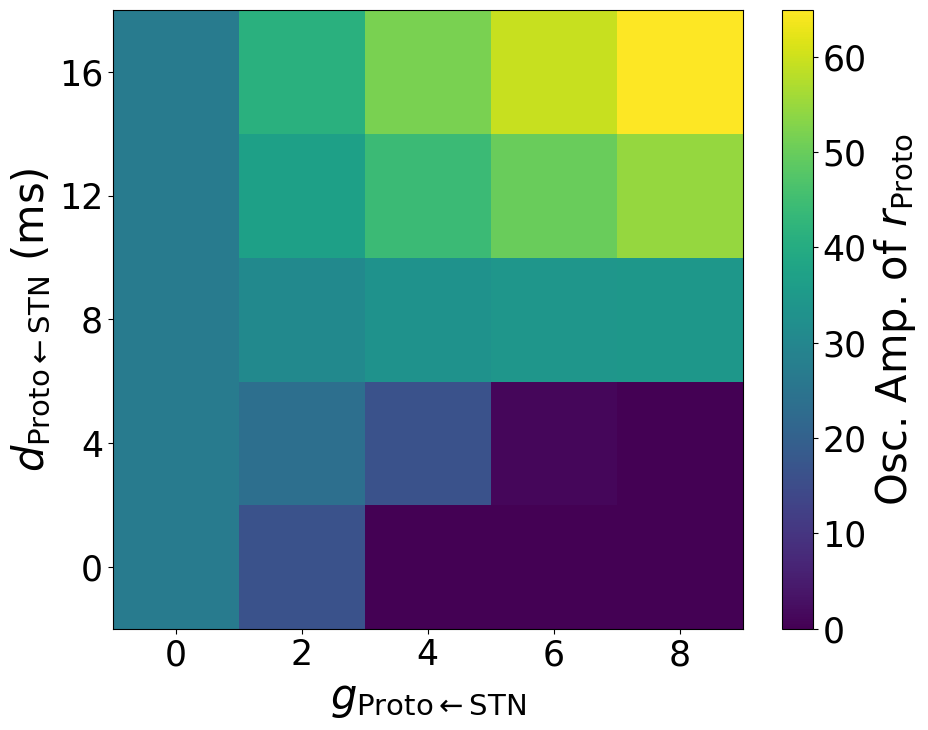

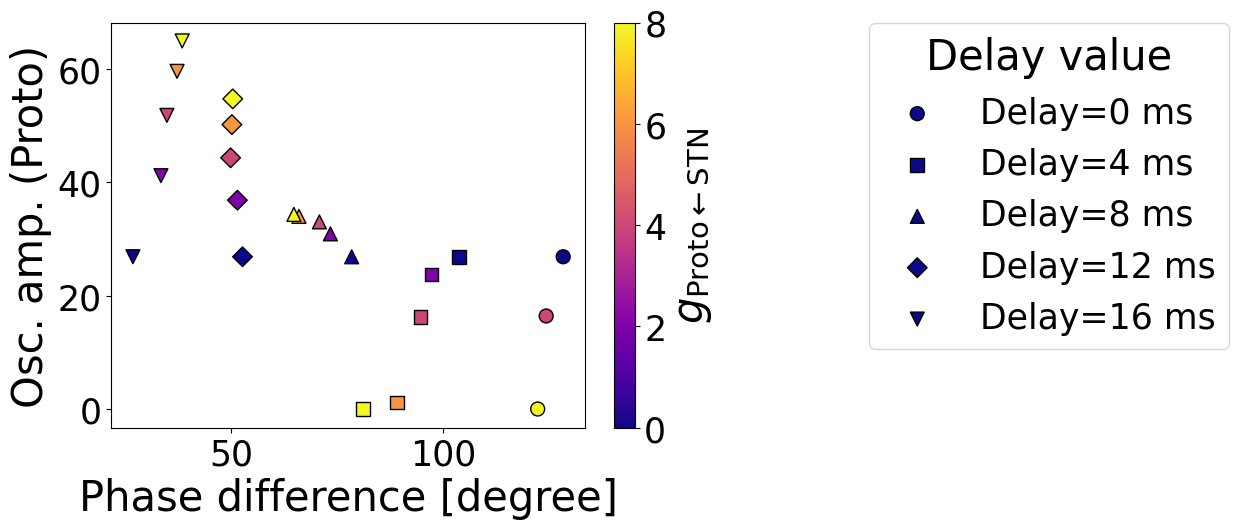

In [6]:
# Suppress specific jitcdde warnings
warnings.filterwarnings("ignore", message="Differential equation does not include a delay term.")
warnings.filterwarnings("ignore", message="You did not explicitly handle initial discontinuities.*")
warnings.filterwarnings("ignore", message="The target time is smaller than the current time.*")

# This model represents population firing rates for basal ganglia nuclei:
# x1: STN (Subthalamic Nucleus)
# x2: Proto (Prototypical Neurons)
# x3: FSI (Fast-Spiking Interneurons)
# x4: D2 (D2 Receptor-Expressing Medium Spiny Neurons)



# Function to create and run the DDE system for specific parameter values
def run_simulation(g21, d):
    # Activation function (sigmoid)
    def f(x):
        return 1/(1+symengine.exp(-x))

    # Parameters
    # Neuron 1
    a1 = 31.3
    b1 = 0.127
    g12 = 0.4
    c1 = -2.33
    t1 = 12
    I1 = 0

    # Neuron 2
    a2 = 108
    b2 = 0.0198
    g24 = 50
    c2 = -2.33
    t2 = 10
    I2 = -30  # Fixed I2 value

    # Neuron 3
    a3 = 41.6
    b3 = 0.0327
    g32 = 4
    c3 = -5.28
    t3 = 20
    I3 = -20

    # Neuron 4
    a4 = 6.61
    b4 = 0.0326
    g43 = 10
    c4 = -5.28
    t4 = 20
    I4 = -80

    # Define the differential equations
    def dde_system():
        """
        Population firing rate model:
                    x3 (FSI)
                  /        \
        x1 (STN) <-> x2 (Proto)   x4 (D2) <---
        """
        # In jitcdde, y(0) is x1 (STN), y(1) is x2 (Proto), y(2) is x3 (FSI), and y(3) is x4 (D2)
        # Delayed variable is accessed using y(i, t-delay)

        # x1 equation
        yield (-y(0) + a1 * f(b1 * (-g12 * y(1, t-d) + I1) - c1)) / t1

        # x2 equation
        yield (-y(1) + a2 * f(b2 * (g21 * y(0) - g24 * y(3) + I2) - c2)) / t2

        # x3 equation
        yield (-y(2) + a3 * f(b3 * (-g32 * y(1) + I3) - c3)) / t3

        # x4 equation
        yield (-y(3) + a4 * f(b4 * (-g43 * y(2) + I4) - c4)) / t4

    # Set up the DDE solver
    DDE = jitcdde(dde_system)

    # Set initial conditions
    initial_conditions = [15, 60, 0.15, 1]  # [x1, x2, x3, x4]
    DDE.constant_past(initial_conditions)

    # Set integration parameters
    DDE.set_integration_parameters()

    # Handle initial discontinuities explicitly to avoid warning
    DDE.initial_discontinuities_handled = True

    # Compile the DDE system (only needed once per run)
    DDE.compile_C()

    # Solve the system
    total_time = 2000
    cutoff_time = 1500  # Start measuring amplitude after this time
    dt = 0.1
    times = np.arange(0, total_time, dt)
    solution = np.zeros((len(times), 4))

    for i, time_point in enumerate(times):
        solution[i] = DDE.integrate(time_point)

    # Get the late portion of the solution for analysis
    cutoff_index = int(cutoff_time / dt)
    x1_late = solution[cutoff_index:, 0]  # STN values after cutoff
    x2_late = solution[cutoff_index:, 1]  # Proto values after cutoff

    # Calculate amplitude as max - min
    amplitude = np.max(x2_late) - np.min(x2_late)
    phase_diff, dominant_freq = calculate_phase_difference(x2_late, x1_late, dt=dt)

    return amplitude, phase_diff

# Define parameter ranges for heatmap
g21_values = np.arange(0,10, 2)  # Range of g21 values
d_values = np.arange(0, 20, 4)   # Range of delay values

# Create matrices to store oscillation amplitudes and phase differences
amplitudes = np.zeros((len(d_values), len(g21_values)))
phase_diffs = np.zeros((len(d_values), len(g21_values)))

# Main loop to fill the amplitude matrix
start_time = time.time()

# Create all parameter combinations
param_combinations = [(i, d, j, g21) for i, d in enumerate(d_values) for j, g21 in enumerate(g21_values)]
total_simulations = len(param_combinations)

# Use tqdm for progress tracking
for i, d, j, g21 in tqdm(param_combinations, desc="Running simulations", total=total_simulations):
    # Run simulation and get amplitude and phase difference
    amplitude, phase_diff = run_simulation(g21, d)

    # Store in matrices
    amplitudes[i, j] = amplitude
    phase_diffs[i, j] = phase_diff

# Create heatmap for oscillation amplitudes
plt.rcParams.update({
    'font.size': 30,          # Adjust the size as needed
    'axes.titlesize': 30,     # Font size of the axes title
    'axes.labelsize': 30,    # Font size of the axis labels
    'xtick.labelsize': 25,    # Font size of the x-axis tick labels
    'ytick.labelsize': 25,    # Font size of the y-axis tick labels
    'legend.fontsize': 25     # Font size of the legend
})

plt.figure(figsize=(10, 8))
plt.imshow(amplitudes, cmap='viridis', origin='lower', aspect='auto',)
# plt.imshow(amplitudes, cmap='viridis', origin='lower', aspect='auto',
#            extent=[g21_values[0], g21_values[-1], d_values[0], d_values[-1]])

plt.colorbar(label=r'Osc. Amp. of $r_{\text{Proto}}$')
plt.xlabel(r'$g_{\text{Proto}\leftarrow\text{STN}}$')
plt.ylabel(r'$d_{\text{Proto}\leftarrow\text{STN}}$ (ms)')
# plt.title('Heatmap of Proto Oscillation Amplitude')

plt.xticks(np.arange(len(g21_values)), g21_values)
plt.yticks(np.arange(len(d_values)), d_values)

# Add grid
plt.grid(False)

# Save figure
plt.tight_layout()
plt.savefig('oscillation_amplitude_heatmap_d_g.png', dpi=300)

import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual arrays)
phase_diffs_flattened = np.array(phase_diffs).flatten()
amplitudes_flattened = np.array(amplitudes).flatten()
delays = np.repeat(d_values, len(g21_values))  # or use your delay_vals array

unique_delays = np.unique(delays)
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']  # Add more if needed

plt.figure(figsize=(10,6))
for i, d in enumerate(unique_delays):
    idx = delays == d
    plt.scatter(phase_diffs_flattened[idx], amplitudes_flattened[idx], c=g21_values, cmap='plasma', s=100,
                edgecolor='k', marker=markers[i % len(markers)], label=f'Delay={d} ms')

plt.xlabel('Phase difference [degree]')
plt.ylabel('Osc. amp. (Proto)')
# plt.title('Oscillation amplitude vs phase difference', pad=20)
plt.legend(title='Delay value', bbox_to_anchor=(1.6, 1), borderaxespad=0.)
cbar = plt.colorbar()
cbar.set_label(r'$g_{\text{Proto}\leftarrow\text{STN}}$')
plt.tight_layout()  # Leave space on the right for the legend
plt.show()

In [3]:
# Suppress specific jitcdde warnings
warnings.filterwarnings("ignore", message="Differential equation does not include a delay term.")
warnings.filterwarnings("ignore", message="You did not explicitly handle initial discontinuities.*")
warnings.filterwarnings("ignore", message="The target time is smaller than the current time.*")

# Activation function (sigmoid)
def f(x):
    return 1/(1+symengine.exp(-x))

# Define a smoother Heaviside function using sigmoid
# This avoids issues with symengine and makes the transition smoother
def heaviside(t, t0, k=100):
    """
    A smooth approximation of the Heaviside step function
    t: time variable
    t0: step time
    k: steepness of transition (larger k = sharper transition)
    """
    return 1 / (1 + symengine.exp(-k * (t - t0)))

# Define parameters
# Neuron 1
a1 = 31.3
b1 = 0.127
g12 = 0.4
c1 = -2.33
t1 = 12
I1 = 0

# Neuron 2
a2 = 108
b2 = 0.0198
g24 = 50
c2 = -2.33
t2 = 10
I2 = -30  # Fixed I2 value

# Neuron 3
a3 = 41.6
b3 = 0.0327
g32 = 4
c3 = -5.28
t3 = 20
I3 = -20

# Neuron 4
a4 = 6.61
b4 = 0.0326
g43 = 10
c4 = -5.28
t4 = 20
I4 = -80

# Simulation parameters
total_time = 8000
connection_time = 980  # Time to turn on the STN to Proto connection
g21_strength = 2  # Strength of STN to Proto connection when active
dt = 0.1
times = np.arange(0, total_time, dt)

# Define the DDE system with time-dependent connection strength
def create_dde_system(use_heaviside=True, g21_base=0, delay=0):
    """
    Create a DDE system with parameters

    Parameters:
    use_heaviside: If True, use Heaviside function to switch connection at connection_time
    g21_base: Base value for g21 (used when use_heaviside=False)
    delay: Delay in the Proto to STN connection
    """
    def dde_system():
        # Define g21 based on Heaviside function or fixed value
        if use_heaviside:
            g21 = g21_strength * heaviside(t, connection_time)
        else:
            g21 = g21_base

        # x1 equation (STN) with delay
        yield (-y(0) + a1 * f(b1 * (-g12 * y(1, t-delay) + I1) - c1)) / t1

        # x2 equation (Proto)
        yield (-y(1) + a2 * f(b2 * (g21 * y(0) - g24 * y(3) + I2) - c2)) / t2

        # x3 equation (FSI)
        yield (-y(2) + a3 * f(b3 * (-g32 * y(1) + I3) - c3)) / t3

        # x4 equation (D2)
        yield (-y(3) + a4 * f(b4 * (-g43 * y(2) + I4) - c4)) / t4

    return dde_system

# Function to run a simulation with the specified parameters
def run_simulation(use_heaviside=True, g21_base=0, delay=0):
    """Run a full simulation with the specified parameters"""
    # Create the DDE system
    dde_system = create_dde_system(use_heaviside, g21_base, delay)

    # Set up DDE solver
    DDE = jitcdde(dde_system)
    DDE.constant_past([15, 60, 0.15, 1])  # [x1, x2, x3, x4]
    DDE.set_integration_parameters()
    DDE.initial_discontinuities_handled = True
    DDE.compile_C(simplify=False)  # Disable simplification to avoid errors

    # Solve the system
    solution = np.zeros((len(times), 4))
    for i, time_point in enumerate(times):
        solution[i] = DDE.integrate(time_point)

    return solution, times

# Run the three simulations
# 1. No STN effect on Proto (g21=0)
solution1, times1 = run_simulation(use_heaviside=False, g21_base=0, delay=0)

# 2. STN-Proto connection turns on at connection_time, no delay
solution2, times2 = run_simulation(use_heaviside=True, delay=0)

# 3. STN-Proto connection turns on at connection_time, with delay=16
solution3, times3 = run_simulation(use_heaviside=True, delay=16)

# Store solutions and labels
solutions = [solution1, solution2, solution3]
all_times = [times1, times2, times3]

plt.show()
plt.rcParams.update({
    'font.size': 30,  # Adjust the size as needed
    'axes.titlesize': 30,  # Font size of the axes title
    'axes.labelsize': 30,  # Font size of the axis labels
    'xtick.labelsize': 20,  # Font size of the x-axis tick labels
    'ytick.labelsize': 20,  # Font size of the y-axis tick labels
    'legend.fontsize': 20  # Font size of the legend
})

# X-axis control parameters for all plots
x_min = 900  # Start time for x-axis
x_max = 1200  # End time for x-axis

# Define consistent colors for each simulation
sim_colors = ['blue', 'green', 'red']  # Colors for No STN, No delay, Delay=16
stn_color = 'purple'  # Color for STN activity


# Assuming the rest of your code remains the same until the plotting section

# --- PLOTTING ---
plt.figure(figsize=(20, 10))  # Adjust figure size for better layout

# Create a grid layout: 2 rows, 2 columns
# The first three plots will span the first column (3 rows), and the phase diagram will be in the second column
gs = plt.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])

# Plot 1: Proto activity of all 3 simulations in the same plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
for i in range(3):
    ax1.plot(all_times[2-i], solutions[2-i][:, 1], color=sim_colors[2-i])

ax1.axvline(x=connection_time, color='black', linestyle='--', label='STN-Proto connection on')
ax1.set_ylabel(r'$r_{\text{Proto}}$')
ax1.set_xlim(x_min, x_max)  # Set x-axis limits
ax1.set_xticklabels([])  # Remove x-axis tick labels
ax1.set_xlabel('')  # Remove x-axis label
ax1.set_title('Proto Activity for all three cases')
# ax1.legend()
# ax1.grid(True)

# Plot 2: Twin plot for STN and Proto - simulation 2 (no delay)
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column, share x-axis with ax1
ax2_twin = ax2.twinx()

# Plot STN on left axis
ax2.plot(times2, solution2[:, 0], color=stn_color, label='STN')
ax2.set_ylabel(r'$r_{\text{STN}}$', color=stn_color)
ax2.tick_params(axis='y', labelcolor=stn_color)
ax2.set_title('STN and Proto Activity (No Delay)')
ax2.set_xticklabels([])  # Remove x-axis tick labels
ax2.set_xlabel('')  # Remove x-axis label

# Plot Proto on right axis
ax2_twin.plot(times2, solution2[:, 1], color=sim_colors[1], label='Proto')
ax2_twin.set_ylabel(r'$r_{\text{Proto}}$', color=sim_colors[1])
ax2_twin.tick_params(axis='y', labelcolor=sim_colors[1])

# Add the vertical line and title
ax2.axvline(x=connection_time, color='black', linestyle='--')
ax2.set_xlim(x_min, x_max)  # Set x-axis limits
# ax2.grid(True)

# Plot 3: Twin plot for STN and Proto - simulation 3 (with delay)
ax3 = plt.subplot(gs[2, 0])  # Third row, first column, share x-axis with ax1
ax3_twin = ax3.twinx()

# Plot STN on left axis
ax3.plot(times3, solution3[:, 0], color='magenta', label='STN')
ax3.set_title('STN and Proto Activity (With Delay)')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel(r'$r_{\text{STN}}$', color='magenta')
ax3.tick_params(axis='y', labelcolor='magenta')

# Plot Proto on right axis
ax3_twin.plot(times3, solution3[:, 1], color=sim_colors[2], label='Proto')
ax3_twin.set_ylabel(r'$r_{\text{Proto}}$', color=sim_colors[2])
ax3_twin.tick_params(axis='y', labelcolor=sim_colors[2])

# Add the vertical line and title
ax3.axvline(x=connection_time, color='black', linestyle='--')
ax3.set_xlim(x_min, x_max)  # Set x-axis limits
# ax3.grid(True)

# Plot 4: Phase diagram (Proto vs STN) for all simulations
ax4 = plt.subplot(gs[:, 1])  # All rows, second column

# Find indices corresponding to the display time window
start_idx1 = np.abs(times1 - x_min).argmin()
start_idx2 = np.abs(times2 - x_min).argmin()
start_idx3 = np.abs(times3 - x_min).argmin()

end_idx1 = np.abs(times1 - x_max).argmin()
end_idx2 = np.abs(times2 - x_max).argmin()
end_idx3 = np.abs(times3 - x_max).argmin()

# Find indices corresponding to the connection time
connection_idx1 = np.abs(times1 - connection_time).argmin()
connection_idx2 = np.abs(times2 - connection_time).argmin()
connection_idx3 = np.abs(times3 - connection_time).argmin()

# Plot phase trajectories only for the specified time window
# Proto on x-axis, STN on y-axis
line1, = ax4.plot(solution2[start_idx2:, 1], solution2[start_idx2:, 0], color=sim_colors[1], label='No delay')
line2, = ax4.plot(solution3[start_idx3:, 1], solution3[start_idx3:, 0], color=sim_colors[2], label='With delay')
line3, = ax4.plot(solution1[start_idx1:, 1], solution1[start_idx1:, 0], color=sim_colors[0], label='No STN')

# Mark the connection activation points if they fall within the display window
if x_min <= connection_time <= x_max:
    marker, = ax4.plot(solution1[connection_idx1, 1], solution1[connection_idx1, 0], 'o', color='black', markersize=8, label='Connection activation')

# Add arrow to indicate direction of phase trajectory for simulation 2
# Choose a point after the connection that falls within the display window
if connection_idx2 + 50 <= end_idx2:
    arrow_idx = connection_idx2 + 50
    ax4.annotate('',
                xy=(solution2[arrow_idx, 1], solution2[arrow_idx, 0]),
                xytext=(solution2[arrow_idx-20, 1], solution2[arrow_idx-20, 0]),
                arrowprops=dict(facecolor=sim_colors[1], shrink=0.05, width=2))

if connection_idx3 + 50 <= end_idx3:
    arrow_idx = connection_idx3 + 50
    ax4.annotate('',
                xy=(solution3[arrow_idx, 1], solution3[arrow_idx, 0]),
                xytext=(solution3[arrow_idx-20, 1], solution3[arrow_idx-20, 0]),
                arrowprops=dict(facecolor=sim_colors[2], shrink=0.05, width=2))

if connection_idx1 + 50 <= end_idx1:
    arrow_idx = connection_idx1 + 50
    ax4.annotate('',
                xy=(solution1[arrow_idx, 1], solution1[arrow_idx, 0]),
                xytext=(solution1[arrow_idx-20, 1], solution1[arrow_idx-20, 0]),
                arrowprops=dict(facecolor=sim_colors[0], shrink=0.05, width=2))

ax4.set_xlabel(r'$r_{\text{Proto}}$')
ax4.set_ylabel(r'$r_{\text{STN}}$')
ax4.set_title(f'Phase Diagram from {x_min}ms to 8000ms')

# Manually specify the order of handles and labels
handles = [line3, line1, line2]
labels = ['No STN', 'No delay', 'With delay']
ax4.legend(handles, labels)

# Adding a legend for the connection activation markers
ax4.plot([], [], 'o', color='black', label='Connection activation')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap, leave space for the title
plt.savefig('stn_proto_connection_analysis.png', dpi=300)
plt.show()

error: unknown target CPU 'apple-m3'
note: valid target CPU values are: nocona, core2, penryn, bonnell, atom, silvermont, slm, goldmont, goldmont-plus, tremont, nehalem, corei7, westmere, sandybridge, corei7-avx, ivybridge, core-avx-i, haswell, core-avx2, broadwell, skylake, skylake-avx512, skx, cascadelake, cooperlake, cannonlake, icelake-client, rocketlake, icelake-server, tigerlake, sapphirerapids, alderlake, raptorlake, meteorlake, arrowlake, arrowlake-s, lunarlake, gracemont, pantherlake, sierraforest, grandridge, graniterapids, graniterapids-d, emeraldrapids, clearwaterforest, knl, knm, k8, athlon64, athlon-fx, opteron, k8-sse3, athlon64-sse3, opteron-sse3, amdfam10, barcelona, btver1, btver2, bdver1, bdver2, bdver3, bdver4, znver1, znver2, znver3, znver4, znver5, x86-64, x86-64-v2, x86-64-v3, x86-64-v4


SystemExit: error: command '/usr/bin/clang' failed with exit code 1

/Users/tsekanap/Documents/github/basal_ganglia_model/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Scatter plot: Oscillation amplitude vs phase difference for varying delays
def compute_phase_amp(x1, x2, dt, power_thresh=1e-2):
    # Demean
    x1 = x1 - np.mean(x1)
    x2 = x2 - np.mean(x2)
    # FFT
    n = len(x1)
    freqs = np.fft.rfftfreq(n, d=dt)
    fft1 = np.fft.rfft(x1)
    fft2 = np.fft.rfft(x2)
    power1 = np.abs(fft1)**2
    # Dominant frequency (ignore DC)
    dom_idx = np.argmax(power1[1:]) + 1
    dom_freq = freqs[dom_idx]
    # Power threshold
    if power1[dom_idx] < power_thresh:
        return None, None, None
    # Phase at dominant frequency
    phase1 = np.angle(fft1[dom_idx])
    phase2 = np.angle(fft2[dom_idx])
    phase_diff = np.angle(np.exp(1j*(phase2 - phase1)))  # wrapped to [-pi, pi]
    # Amplitude (peak-to-peak of x2)
    amp = np.max(x2) - np.min(x2)
    return amp, phase_diff, dom_freq

amplitudes = []
phase_diffs = []
dom_freqs = []
delay_vals = []
g21_vals = []
power_thresh = 1e-2  # Adjust as needed

for i, d in enumerate(d_values):
    for j, g21 in enumerate(g21_values):
        # Run simulation and get full solution
        def run_full_sim(g21, d):
            def f(x):
                return 1/(1+symengine.exp(-x))
            a1, b1, g12, c1, t1, I1 = 31.3, 0.127, 0.4, -2.33, 12, 0
            a2, b2, g24, c2, t2, I2 = 108, 0.0198, 50, -2.33, 10, -30
            a3, b3, g32, c3, t3, I3 = 41.6, 0.0327, 4, -5.28, 20, -20
            a4, b4, g43, c4, t4, I4 = 6.61, 0.0326, 10, -5.28, 20, -80
            def dde_system():
                yield (-y(0) + a1 * f(b1 * (-g12 * y(1, t-d) + I1) - c1)) / t1
                yield (-y(1) + a2 * f(b2 * (g21 * y(0) - g24 * y(3) + I2) - c2)) / t2
                yield (-y(2) + a3 * f(b3 * (-g32 * y(1) + I3) - c3)) / t3
                yield (-y(3) + a4 * f(b4 * (-g43 * y(2) + I4) - c4)) / t4
            DDE = jitcdde(dde_system)
            initial_conditions = [15, 60, 0.15, 1]
            DDE.constant_past(initial_conditions)
            DDE.set_integration_parameters()
            DDE.initial_discontinuities_handled = True
            DDE.compile_C()
            total_time = 2000
            cutoff_time = 1500
            dt = 0.1
            times = np.arange(0, total_time, dt)
            solution = np.zeros((len(times), 4))
            for idx, time_point in enumerate(times):
                solution[idx] = DDE.integrate(time_point)
            cutoff_index = int(cutoff_time / dt)
            x1_late = solution[cutoff_index:, 0]
            x2_late = solution[cutoff_index:, 1]
            return x1_late, x2_late, dt
        x1_late, x2_late, dt = run_full_sim(g21, d)
        amp, phase_diff, dom_freq = compute_phase_amp(x1_late, x2_late, dt, power_thresh)
        if amp is not None:
            amplitudes.append(amp)
            phase_diffs.append(phase_diff)
            dom_freqs.append(dom_freq)
            delay_vals.append(d)
            g21_vals.append(g21)

plt.figure(figsize=(8,6))
plt.scatter(phase_diffs, amplitudes, c=delay_vals, cmap='viridis', s=100, edgecolor='k')
plt.xlabel('Phase difference (Proto - STN) [rad]')
plt.ylabel('Oscillation amplitude (Proto)')
plt.title('Oscillation amplitude vs phase difference')
cbar = plt.colorbar()
cbar.set_label('Delay (ms)')
plt.tight_layout()
plt.show()


In [ ]:
from scipy.fft import fft, fftfreq

def calculate_phase_difference(signal1, signal2, dt, min_power_threshold=1e-6):
        """
        Calculate the phase difference between two populations' firing rates.

        Args:
            pop1 (str): The name of the first population.
            pop2 (str): The name of the second population.
            bin_width (int): The width of each bin in milliseconds.
            drop_initial (int): The initial portion of data to drop in milliseconds.

        Returns:
        --------
        phase_diff : float
            Phase difference in radians (wrapped to [-π, π])
        dominant_freq : float
            Dominant frequency in Hz
        """

        # FFT of both signals
        fft1 = fft(signal1 - signal1.mean())
        fft2 = fft(signal2 - signal2.mean())

        fs = 1000.0 / dt  # Sampling frequency in Hz

        # Frequency array (positive frequencies only)
        freqs = fftfreq(len(signal1), 1 / fs)
        pos_freqs = freqs[:len(freqs) // 2]
        pos_fft1 = fft1[:len(freqs) // 2]
        pos_fft2 = fft2[:len(freqs) // 2]

        # Calculate power spectra
        power1 = np.abs(pos_fft1) ** 2
        power2 = np.abs(pos_fft2) ** 2

        # Find dominant frequency from signal1 (our reference)
        dominant_idx = np.argmax(np.abs(pos_fft1))
        dominant_freq = pos_freqs[dominant_idx]
        max_power1 = power1[dominant_idx]
        max_power2 = power2[dominant_idx]

        # Check if signals have sufficient power at the dominant frequency
        if max_power1 < min_power_threshold:
            print(f"Warning: Signal 1 has no significant frequency components (likely constant or noise)")
            return np.nan, np.nan

        if max_power2 < min_power_threshold:
            print("Warning: Signal 2 has no significant frequency components (likely constant or noise)")
            return np.nan, np.nan

        # Extract phases at dominant frequency
        phase1 = np.angle(pos_fft1[dominant_idx])
        phase2 = np.angle(pos_fft2[dominant_idx])

        # Calculate phase difference with signal1 as reference
        phase_diff = phase2 - phase1

        # Wrap to [-π, π]
        phase_diff = np.degrees(np.arctan2(np.sin(phase_diff), np.cos(phase_diff)))

        return round(phase_diff, 1), round(dominant_freq, 1)

Running simulations:  16%|█▌        | 4/25 [00:02<00:14,  1.46it/s]

Running simulations:  20%|██        | 5/25 [00:03<00:13,  1.49it/s]

Running simulations: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]


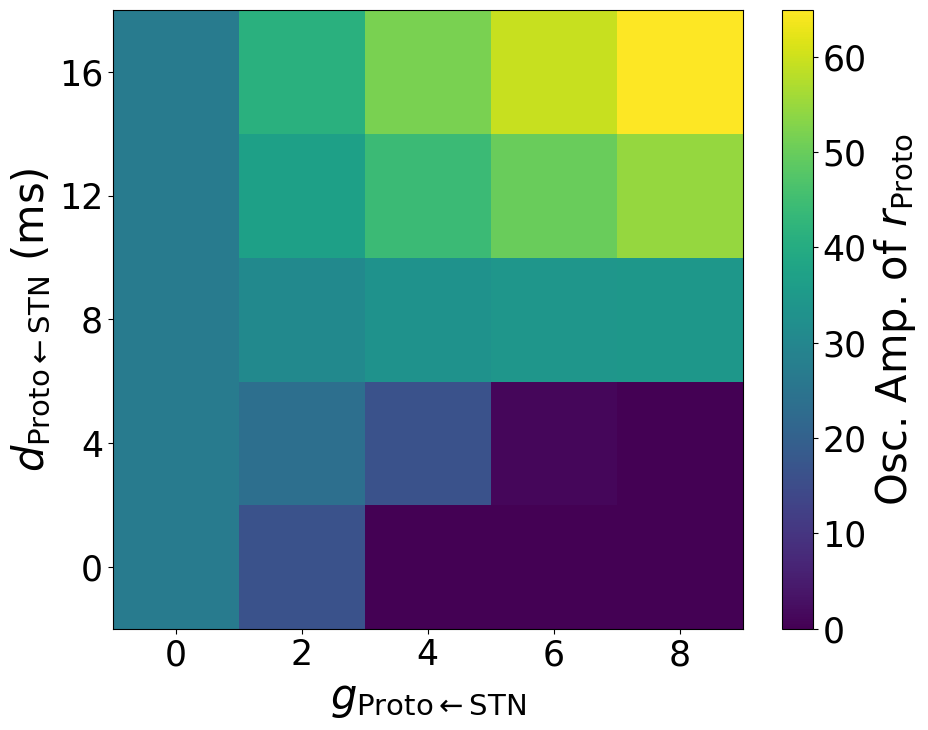

In [18]:
# Suppress specific jitcdde warnings
warnings.filterwarnings("ignore", message="Differential equation does not include a delay term.")
warnings.filterwarnings("ignore", message="You did not explicitly handle initial discontinuities.*")
warnings.filterwarnings("ignore", message="The target time is smaller than the current time.*")

# This model represents population firing rates for basal ganglia nuclei:
# x1: STN (Subthalamic Nucleus)
# x2: Proto (Prototypical Neurons)
# x3: FSI (Fast-Spiking Interneurons)
# x4: D2 (D2 Receptor-Expressing Medium Spiny Neurons)

# Function to create and run the DDE system for specific parameter values
def run_simulation(g21, d):
    # Activation function (sigmoid)
    def f(x):
        return 1/(1+symengine.exp(-x))

    # Parameters
    # Neuron 1
    a1 = 31.3
    b1 = 0.127
    g12 = 0.4
    c1 = -2.33
    t1 = 12
    I1 = 0

    # Neuron 2
    a2 = 108
    b2 = 0.0198
    g24 = 50
    c2 = -2.33
    t2 = 10
    I2 = -30  # Fixed I2 value

    # Neuron 3
    a3 = 41.6
    b3 = 0.0327
    g32 = 4
    c3 = -5.28
    t3 = 20
    I3 = -20

    # Neuron 4
    a4 = 6.61
    b4 = 0.0326
    g43 = 10
    c4 = -5.28
    t4 = 20
    I4 = -80

    # Define the differential equations
    def dde_system():
        """
        Population firing rate model:
                    x3 (FSI)
                  /        \
        x1 (STN) <-> x2 (Proto)   x4 (D2) <---
        """
        # In jitcdde, y(0) is x1 (STN), y(1) is x2 (Proto), y(2) is x3 (FSI), and y(3) is x4 (D2)
        # Delayed variable is accessed using y(i, t-delay)

        # x1 equation
        yield (-y(0) + a1 * f(b1 * (-g12 * y(1, t-d) + I1) - c1)) / t1

        # x2 equation
        yield (-y(1) + a2 * f(b2 * (g21 * y(0) - g24 * y(3) + I2) - c2)) / t2

        # x3 equation
        yield (-y(2) + a3 * f(b3 * (-g32 * y(1) + I3) - c3)) / t3

        # x4 equation
        yield (-y(3) + a4 * f(b4 * (-g43 * y(2) + I4) - c4)) / t4

    # Set up the DDE solver
    DDE = jitcdde(dde_system)

    # Set initial conditions
    initial_conditions = [15, 60, 0.15, 1]  # [x1, x2, x3, x4]
    DDE.constant_past(initial_conditions)

    # Set integration parameters
    DDE.set_integration_parameters()

    # Handle initial discontinuities explicitly to avoid warning
    DDE.initial_discontinuities_handled = True

    # Compile the DDE system (only needed once per run)
    DDE.compile_C()

    # Solve the system
    total_time = 2000
    cutoff_time = 1500  # Start measuring amplitude after this time
    dt = 0.1
    times = np.arange(0, total_time, dt)
    solution = np.zeros((len(times), 4))

    for i, time_point in enumerate(times):
        solution[i] = DDE.integrate(time_point)

    # Get the late portion of the solution for analysis
    cutoff_index = int(cutoff_time / dt)
    x1_late = solution[cutoff_index:, 0]  # STN values after cutoff
    x2_late = solution[cutoff_index:, 1]  # Proto values after cutoff

    # Calculate amplitude as max - min
    amplitude = np.max(x2_late) - np.min(x2_late)
    phase_diff, dominant_freq = calculate_phase_difference(x2_late, x1_late, dt=dt)

    return amplitude, phase_diff

# Define parameter ranges for heatmap
g21_values = np.arange(0,10, 2)  # Range of g21 values
d_values = np.arange(0, 20, 4)   # Range of delay values

# Create matrices to store oscillation amplitudes and phase differences
amplitudes = np.zeros((len(d_values), len(g21_values)))
phase_diffs = np.zeros((len(d_values), len(g21_values)))

# Main loop to fill the amplitude matrix
start_time = time.time()

# Create all parameter combinations
param_combinations = [(i, d, j, g21) for i, d in enumerate(d_values) for j, g21 in enumerate(g21_values)]
total_simulations = len(param_combinations)

# Use tqdm for progress tracking
for i, d, j, g21 in tqdm(param_combinations, desc="Running simulations", total=total_simulations):
    # Run simulation and get amplitude and phase difference
    amplitude, phase_diff = run_simulation(g21, d)

    # Store in matrices
    amplitudes[i, j] = amplitude
    phase_diffs[i, j] = phase_diff

# Create heatmap for oscillation amplitudes
plt.rcParams.update({
    'font.size': 30,          # Adjust the size as needed
    'axes.titlesize': 30,     # Font size of the axes title
    'axes.labelsize': 30,    # Font size of the axis labels
    'xtick.labelsize': 25,    # Font size of the x-axis tick labels
    'ytick.labelsize': 25,    # Font size of the y-axis tick labels
    'legend.fontsize': 25     # Font size of the legend
})

plt.figure(figsize=(10, 8))
plt.imshow(amplitudes, cmap='viridis', origin='lower', aspect='auto',)
# plt.imshow(amplitudes, cmap='viridis', origin='lower', aspect='auto',
#            extent=[g21_values[0], g21_values[-1], d_values[0], d_values[-1]])

plt.colorbar(label=r'Osc. Amp. of $r_{\text{Proto}}$')
plt.xlabel(r'$g_{\text{Proto}\leftarrow\text{STN}}$')
plt.ylabel(r'$d_{\text{Proto}\leftarrow\text{STN}}$ (ms)')
# plt.title('Heatmap of Proto Oscillation Amplitude')

plt.xticks(np.arange(len(g21_values)), g21_values)
plt.yticks(np.arange(len(d_values)), d_values)

# Add grid
plt.grid(False)

# Save figure
plt.tight_layout()
plt.savefig('oscillation_amplitude_heatmap_d_g.png', dpi=300)

import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual arrays)
x = np.array(phase_diffs).flatten()
y = np.array(amplitudes).flatten()
delays = np.repeat(d_values, len(g21_values))  # or use your delay_vals array

unique_delays = np.unique(delays)
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']  # Add more if needed

plt.figure(figsize=(10,6))
for i, d in enumerate(unique_delays):
    idx = delays == d
    plt.scatter(x[idx], y[idx], c=g21_values, cmap='plasma', s=100,
                edgecolor='k', marker=markers[i % len(markers)], label=f'Delay={d} ms')

plt.xlabel('Phase difference [degree]')
plt.ylabel('Osc. amp. (Proto)')
# plt.title('Oscillation amplitude vs phase difference', pad=20)
plt.legend(title='Delay value', bbox_to_anchor=(1.6, 1), borderaxespad=0.)
cbar = plt.colorbar()
cbar.set_label(r'$g_{\text{Proto}\leftarrow\text{STN}}$')
plt.tight_layout()  # Leave space on the right for the legend
plt.show()